In [64]:
%pip install qiskit
%pip install 'qiskit[nature]'
%pip install 'qiskit-nature[pyscf]' -U
%pip install matplotlib

In [65]:
%pip show qiskit_nature 
%pip show pyscf

Name: qiskit-nature
Version: 0.5.1
Summary: Qiskit Nature: A library of quantum computing chemistry/physics experiments
Home-page: https://github.com/Qiskit/qiskit-nature
Author: Qiskit Nature Development Team
Author-email: hello@qiskit.org
License: Apache-2.0
Location: /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages
Requires: h5py, numpy, psutil, qiskit-terra, rustworkx, scikit-learn, scipy, setuptools, typing-extensions
Required-by: 
Name: pyscf
Version: 2.1.1
Summary: PySCF: Python-based Simulations of Chemistry Framework
Home-page: http://www.pyscf.org
Author: Qiming Sun
Author-email: osirpt.sun@gmail.com
License: Apache License 2.0
Location: /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages
Requires: h5py, numpy, scipy
Required-by: 


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal

In [103]:
from qiskit.algorithms.optimizers import GradientDescent

def learning_rate():
    power = 0.4
    constant_coeff = 0.1
    def powerlaw():
        n = 0
        while True:
            yield constant_coeff * (n ** power)
            n += 1

    return powerlaw()

def f(x):
    return np.cos(x[0])**2*np.sin(x[1])**2 + np.cos(x[0])**2*np.sin(x[1])**2

initial_point = np.array([1, 0.5])

optimizer1 = GradientDescent(maxiter=40, learning_rate=learning_rate)
result = optimizer1.minimize(fun=f, x0=initial_point)

print(f"Found minimum {result.x} at a value of {result.fun} using {result.nfev} evaluations.")

Found minimum [ 1.28419458e+00 -8.85993935e-04] at a value of 1.2546576894110744e-07 using 120 evaluations.


Text(0.5, 0, 'P')

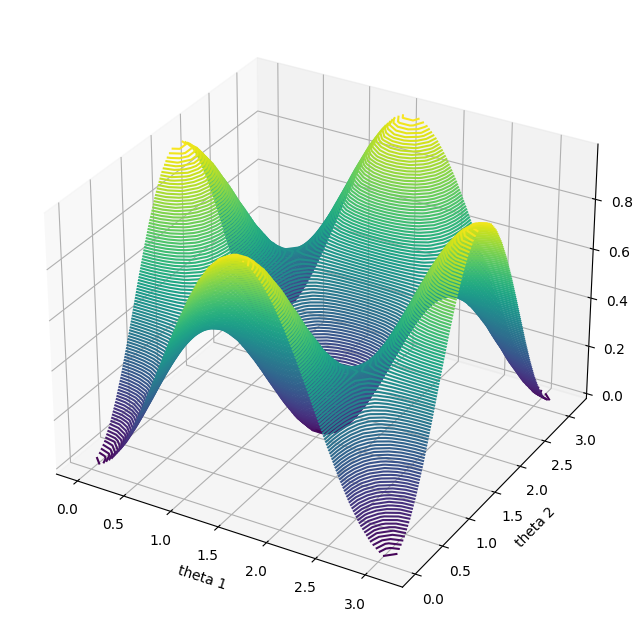

In [93]:
theta1 = np.linspace(0, np.pi, 30)
theta2 = np.linspace(0, np.pi, 30)

def RyTransitionProbability(theta1,theta2):
  z = np.empty((len(theta1),len(theta2)))
  for i in range(len(theta1)):
    for j in range(len(theta2)):
      z[i,j] = np.cos(theta1[i])**2*np.sin(theta2[j])**2 + np.cos(theta2[j])**2*np.sin(theta1[i])**2
  return z

z = RyTransitionProbability(theta1,theta2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(theta1, theta2, z, 100, cmap='viridis')
ax.set_xlabel('theta 1')
ax.set_ylabel('theta 2')
ax.set_zlabel('P')

Evaluating QNGD optimizers with varying hyperparms on $H_2$:

In [142]:
#TODO: Implement using quantum chemistry library
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)
print(type(H2_op))

<class 'qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp'>


QNGD class using Qiskit GradientDescent object. This learning rate function causes the step sizes to decrease over time.

In [137]:
class QNGD(GradientDescent):

    def  __init__(self, power, constant_coeff):
        self.power = power
        self.constant_coeff = constant_coeff
        GradientDescent.__init__(self, maxiter=30, learning_rate=self.learning_rate)

    def learning_rate(self):
        def powerlaw():
            n = 0
            while True:
                yield self.constant_coeff * (n ** self.power)
                n += 1

        return powerlaw()

    def run(self, f, initial_point):
        result = self.minimize(fun=f, x0=initial_point)
        print(f"Found minimum {result.x} at a value of {result.fun} using {result.nfev} evaluations.")
        return result

Experiement 1: Comparing accuracy of Qiskit Gradient Decent on $H_2$ using different powers. Larger powers take bigger steps over the evaluations, ie. model converges faster.

In [138]:
powers = np.linspace(0.1,0.9,9)
constant = 0.1
optimizers = [QNGD(power=p, constant_coeff=constant) for p in powers]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
              quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ')

Optimization complete      


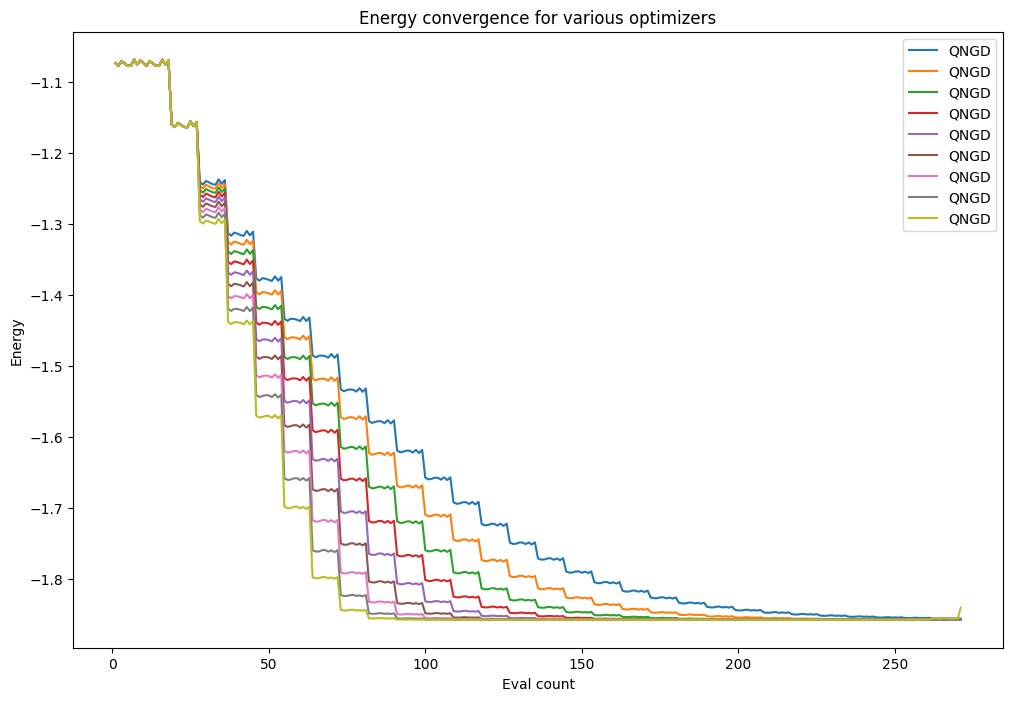

In [139]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')

In [140]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


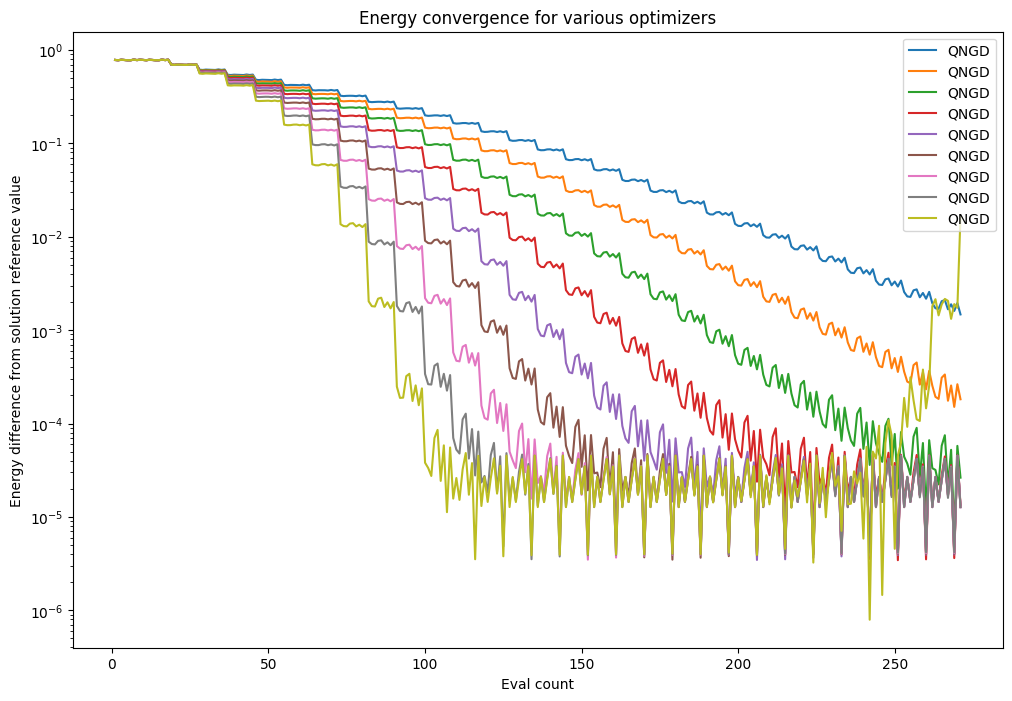

In [141]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], abs(ref_value - converge_vals[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right')